In [1]:
from transformers import TrOCRProcessor
from transformers import VisionEncoderDecoderModel

import os
import torch
import cv2
import shutil
import zipfile
import numpy as np
from tqdm import tqdm
import pydicom as dicom
import pydicom.pixel_data_handlers.util as util
import matplotlib.pyplot as plt

from doctr.models import detection_predictor

/root/apoorva/digipath/lib64/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from run_digipath_pipeline import TextRedaction, update_headers, save_headers_ascsv
from data_utils import run_digipath_deid, convert_to_1x
script_dir = '/root/apoorva/duke_digipath/'
craft_model_dir = os.path.join(script_dir,'model_weights/craft_models/craft_mlt_25k.pth')
fpr_model_dir = os.path.join(script_dir, 'model_weights/tissue_text_models/tissue_text.pth')

out_dir = '/root/apoorva/sample_digipath/'
batch_size = 16
cuda_bool = False
if cuda_bool is True:
    device='cuda'
else:
    device='cpu'
################################################


In [3]:
#Read an image
image_dirpath = '/DDN_storage/PHI/PHI_staging/'
list_files = os.listdir(image_dirpath)

def unzip_folder(zip_path,extract_path):
    with zipfile.ZipFile(zip_path,'r') as zip_ref:
        zip_ref.extractall(extract_path)

def run_deid(series_path):
    text_det = TextRedaction(craft_model_dir, cuda_bool, device, "craft", fpr_model_dir)
    #give a list of headers in a series
    base_dir = series_path
    for files_ in os.listdir(base_dir):
        if 'level-0.dcm' in files_:
            ip_paths=[files_] 
            #ds = dicom.dcmread(series_path+'/'+files_)
            #img = convert_to_1x(ds)
            #if ds.PhotometricInterpretation=='YBR_FULL_422':
            #    image = util.convert_color_space(img,"YBR_FULL_422","RGB")
            #cv2.imwrite('/root/apoorva/jpeg/'+files_.split('/')[-1].replace('.dcm','.jpeg'),image)
    headers = run_digipath_deid(ip_paths, base_dir)
    ########################################################
    digipath_headers,bboxes = text_det.run_textredaction(headers, batch_size)
    return headers,bboxes

16


  0%|          | 0/10 [00:00<?, ?it/s]

16


 10%|█         | 1/10 [00:05<00:52,  5.82s/it]

(1192, 168, 3)
16


 20%|██        | 2/10 [00:17<01:15,  9.47s/it]

(1054, 304, 3)
16


 30%|███       | 3/10 [00:26<01:04,  9.20s/it]

(888, 604, 3)
16


 40%|████      | 4/10 [00:34<00:50,  8.48s/it]

(832, 312, 3)
16


 50%|█████     | 5/10 [00:52<01:00, 12.08s/it]

(764, 558, 3)
16


 60%|██████    | 6/10 [01:04<00:47, 11.97s/it]

(826, 526, 3)
16


 70%|███████   | 7/10 [01:36<00:55, 18.53s/it]

(689, 319, 3)
16


 80%|████████  | 8/10 [01:56<00:37, 18.92s/it]

(689, 337, 3)
16


 90%|█████████ | 9/10 [02:17<00:19, 19.58s/it]

(1226, 428, 3)
16


100%|██████████| 10/10 [02:31<00:00, 15.11s/it]

(984, 366, 3)


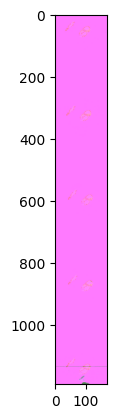

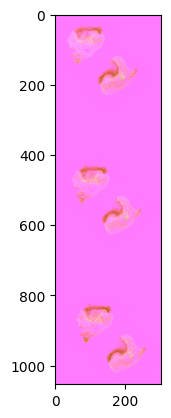

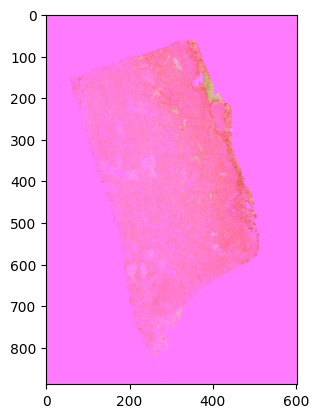

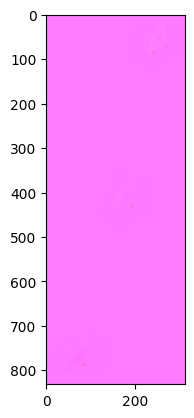

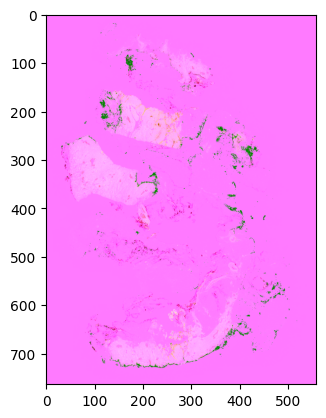

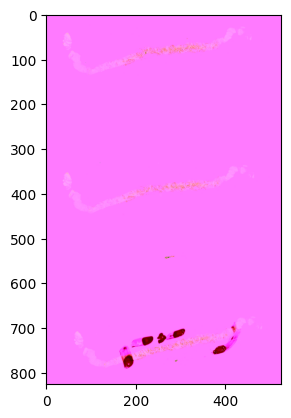

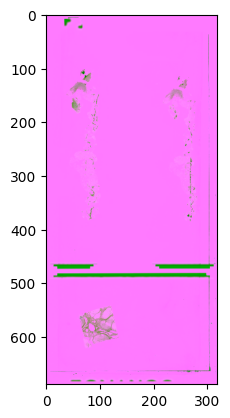

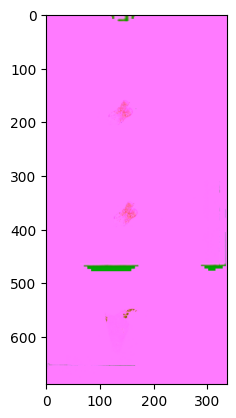

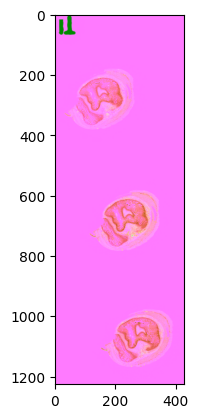

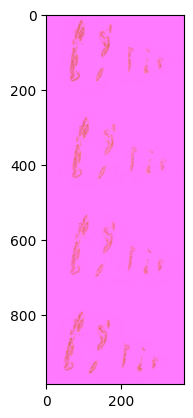

In [4]:
from pydicom.encaps import decode_data_sequence
from data_utils import convert_to_1x
import multiprocessing
num_processes = multiprocessing.cpu_count()
print(num_processes)

image_dirpath = '/DDN_storage/PHI/PHI_staging/'
list_files = os.listdir(image_dirpath)
for each_study in tqdm(list_files[0:10]):
    all_files = (os.listdir(image_dirpath+each_study))
    each_series = each_study+'.zip'
    zip_file_path = image_dirpath+each_study+'/'+each_series
    extracted_folder_path = '/root/apoorva/sample_digipath/'
    unzip_folder(zip_file_path,extracted_folder_path)
    ##########Series Extracted
    series_path = extracted_folder_path+each_series.split('.zip')[0]
    pixel_list = run_deid(series_path+'/')
    shutil.rmtree(series_path)

In [9]:
im.shape,ds.NumberOfFrames

((1208, 498, 3), '150396')

In [24]:
for i in range(len(frames)):
    convert_frames(frames[i])

In [5]:
ocr_model_dir= '/root/apoorva/trocr_finetuned_Z6T0IsL/trocr_finetuned/'
processor = TrOCRProcessor.from_pretrained(ocr_model_dir)
predictor = VisionEncoderDecoderModel.from_pretrained(ocr_model_dir)

In [18]:

if len(pixel_list)>0:
    pixel_list_combined= torch.cat(pixel_list,dim=0)
    generated_ids_ = predictor.generate(pixel_list_combined,max_length=96)

torch.Size([3, 3, 384, 384])


In [8]:
rec_text_list = processor.batch_decode(generated_ids_,skip_special_tokens=True)

In [16]:
pixel_list.append(pixel_list[0])